In [7]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（同じ縮退ペア間のみ）
w3 = 0.2      # 3体相互作用（全てのトリプレット間）

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義（フェルミ符号を含む） ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン ====
pairs = [(0,1), (2,3), (4,5)]
H2 = np.zeros((dim, dim))

for (a,b) in pairs:
    for i, s in enumerate(basis):
        # 密度項（両方占有）
        if s[a] == 1 and s[b] == 1:
            H2[i, i] += v

        # 交換項 a→b
        if s[a] == 1 and s[b] == 0:
            s2, sign = apply_cdag_c(s, b, a)
            if s2 in basis:
                j = basis.index(s2)
                H2[i, j] += v * sign

        # 交換項 b→a（逆方向も入れる）
        if s[b] == 1 and s[a] == 0:
            s2, sign = apply_cdag_c(s, a, b)
            if s2 in basis:
                j = basis.index(s2)
                H2[i, j] += v * sign

# ==== 3体ハミルトニアン ====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

# 全ての triplet → triplet 結合を入れる
for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            # T2をすべて占有している場合のみ作用
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # まず T2 をアニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # 次に T1 を作る
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = H # Hermitize（実対称に）

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))
print(H)

# ==== 固有値 ====
eigvals, _ = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

Hamiltonian matrix (dim=20):
[[1.5 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.2 0.
  0.  0.2]
 [0.3 1.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  2.3 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.3 2.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  2.3 0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  3.  0.3 0.3 0.  0.  0.  0.3 0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 3.  0.  0.3 0.  0.  0.  0.3 0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 0.  3.  0.3 0.  0.  0.  0.  0.3 0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0.3 3.  0.  0.  0.  0.  0.  0.3 0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  4.3 0.  0.  0.  0.  0.  0.3 0.  0.
  0.  0. ]
 [0.2 0.  0.  0.  0.3 0.  0.  0.  0.  0.  2.5 0.  0.  0.  0.  0.  0.2 0.
  0.  0.2]
 [0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.  0.  3

In [8]:
# --- 虚数成分があるかどうかの確認 ---
# for label, coeff in H.to_list():
#     if np.iscomplex(coeff) and abs(coeff.imag) > 1e-12:
#         print(label, coeff)


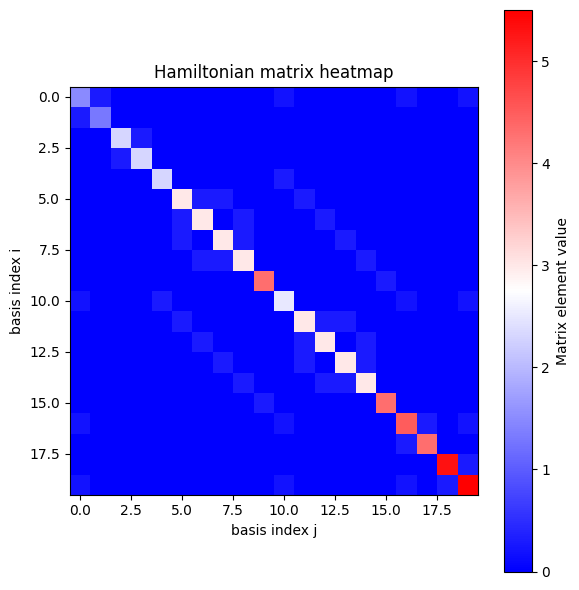

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(H, cmap="bwr", interpolation="nearest")
plt.colorbar(label="Matrix element value")
plt.title("Hamiltonian matrix heatmap")
plt.xlabel("basis index j")
plt.ylabel("basis index i")
plt.tight_layout()
plt.show()

In [10]:
# --- SparsePauliOp を JSON に保存（複素数は [re, im] で保存） ---
# import json

# def save_sparse_pauli_op(op, path: str):
#     # op.to_list() -> List[Tuple[str, complex]]
#     serializable = [[label, [float(c.real), float(c.imag)]] for label, c in op.to_list()]
#     with open(path, "w", encoding="utf-8") as f:
#         json.dump(serializable, f, indent=2)

# def load_sparse_pauli_op(path: str):
#     from qiskit.quantum_info import SparsePauliOp
#     with open(path, "r", encoding="utf-8") as f:
#         data = json.load(f)  # [[label, [re, im]], ...]
#     lst = [(label, complex(re, im)) for label, (re, im) in data]
#     return SparsePauliOp.from_list(lst)

# 使い方
# save_sparse_pauli_op(H, "qubit_ham.json")
# qubit_ham_loaded = load_sparse_pauli_op("qubit_ham.json")

# print(qubit_ham_loaded == H)  # True になるはず

In [11]:
import itertools
import numpy as np
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper

# --- パラメータ設定 ---
N_orb = 4  # 軌道数（例：6軌道）
np.random.seed(0)

# --- 1体・2体・3体の相互作用係数を定義（ランダム） ---
t = np.random.randn(N_orb, N_orb)
V2 = np.random.randn(N_orb, N_orb, N_orb, N_orb)
V3 = np.random.randn(N_orb, N_orb, N_orb, N_orb, N_orb, N_orb)

# --- FermionicOp 形式でHamiltonianを構築 ---
terms = {}

# 1体項: a†_i a_j
for i, j in itertools.product(range(N_orb), repeat=2):
    label = f"+_{i} -_{j}"
    terms[label] = terms.get(label, 0.0) + t[i, j]

# 2体項: a†_i a†_j a_l a_k
for i, j, k, l in itertools.product(range(N_orb), repeat=4):
    label = f"+_{i} +_{j} -_{l} -_{k}"
    terms[label] = terms.get(label, 0.0) + 0.25 * V2[i, j, k, l]

# 3体項: a†_i a†_j a†_k a_n a_m a_l
for i, j, k, l, m, n in itertools.product(range(N_orb), repeat=6):
    label = f"+_{i} +_{j} +_{k} -_{n} -_{m} -_{l}"
    terms[label] = terms.get(label, 0.0) + (1/36) * V3[i, j, k, l, m, n]

# Fermionic Hamiltonian operator
fermionic_ham = FermionicOp(terms, num_spin_orbitals=N_orb)
fermionic_ham = 0.5 * (fermionic_ham + fermionic_ham.adjoint())

# --- Jordan-Wigner変換 ---
mapper = JordanWignerMapper()
qubit_ham = mapper.map(fermionic_ham)

# --- 結果の表示 ---
print("=== Fermionic Hamiltonian ===")
print(fermionic_ham)
print("\n=== Pauli-encoded Hamiltonian ===")
print(qubit_ham)

=== Fermionic Hamiltonian ===
Fermionic Operator
number spin orbitals=4, number terms=4368
  1.764052345967664 * ( +_0 -_0 )
+ 1.1338575992585953 * ( +_0 -_1 )
+ 0.4377595661560907 * ( +_0 -_2 )
+ 1.5009654621742257 * ( +_0 -_3 )
+ 1.1338575992585953 * ( +_1 -_0 )
+ -0.977277879876411 * ( +_1 -_1 )
+ 0.6803434597319808 * ( +_1 -_2 )
+ -0.014841095902434737 * ( +_1 -_3 )
+ 0.4377595661560907 * ( +_2 -_0 )
+ 0.6803434597319808 * ( +_2 -_1 )
+ 0.144043571160878 * ( +_2 -_2 )
+ 0.9490683698542004 * ( +_2 -_3 )
+ 1.5009654621742257 * ( +_3 -_0 )
+ -0.014841095902434737 * ( +_3 -_1 )
+ 0.9490683698542004 * ( +_3 -_2 )
+ 0.33367432737426683 * ( +_3 -_3 )
+ 0.37351976828940153 * ( +_0 +_0 -_0 -_0 )
+ -0.1366180014244892 * ( +_0 +_0 -_1 -_0 )
+ -0.16260376823838127 * ( +_0 +_0 -_2 -_0 )
+ -0.08458369963099649 * ( +_0 +_0 -_3 -_0 )
+ -0.46476745707717937 * ( +_0 +_0 -_0 -_1 )
+ 0.08301482702014763 * ( +_0 +_0 -_1 -_1 )
+ 0.0004013142256003993 * ( +_0 +_0 -_2 -_1 )
+ -0.00873378292425081 * ( +_0 

In [12]:
# --- 虚数成分があるかどうかの確認 ---
for label, coeff in qubit_ham.to_list():
    if np.iscomplex(coeff) and abs(coeff.imag) > 1e-12:
        print(label, coeff)


In [ ]:
import numpy as np
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.quantum_info import SparsePauliOp

num_orbitals = 6
delta = 1.0    
v = 0.3       
w3 = 0.2

pairs = [(0,1), (2,3), (4,5)]
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]

terms: dict[str, complex] = {}

def add_term(label_ops, coeff):
    s = " ".join([f"{op}_{idx}" for op, idx in label_ops])
    terms[s] = terms.get(s, 0.0) + coeff

# --- 1体項
for i in range(num_orbitals):
    add_term([('+', i), ('-', i)], delta * (i // 2))

# --- 2体項
for (a, b) in pairs:
    for (c, d) in pairs:
        add_term([('+', a), ('+', b), ('-', d), ('-', c)], v)            

# --- 3体項
for T1 in triplets:
    for T2 in triplets:
        ops = [( '+', i) for i in sorted(T1)] + [('-', j) for j in sorted(T2)]
        add_term(ops, w3)

ferm_op = FermionicOp(terms, num_spin_orbitals=num_orbitals)
mapper = JordanWignerMapper()
qubit_op: SparsePauliOp = mapper.map(ferm_op)

# ==== 次元情報 ====
# n_qubits = qubit_op.num_qubits
# dim = 2 ** n_qubits

print("JW-mapped Pauli terms:", len(qubit_op))
# print(f"Number of qubits: {n_qubits}")
# print(f"Hamiltonian matrix dimension: {dim} * {dim}")


JW-mapped Pauli terms: 132
Number of qubits: 6
Hamiltonian matrix dimension: 64 * 64


In [14]:
import numpy as np
import math

# 量子ビット数と全空間サイズ
n_qubits = qubit_op.num_qubits
dim = 2 ** n_qubits

# 行列化（疎→密でもOK）
try:
    H = qubit_op.to_spmatrix().toarray()
except Exception:
    H = qubit_op.to_matrix()

# N=3 セクターの基底インデックス（ビットポップカウント=3）
sector = [s for s in range(dim) if bin(s).count("1") == 3]
print("C(6,3) expected:", math.comb(6,3), " / sector len:", len(sector))  # ← 20 を確認

# 20×20 部分行列を抽出
H_20 = H[np.ix_(sector, sector)]
print("Projected Hamiltonian shape:", H_20.shape)  # (20, 20)

# 固有値例
evals, _ = np.linalg.eigh(H_20)
print("lowest 5 eigenvalues:", np.round(evals[:5], 6))


C(6,3) expected: 20  / sector len: 20
Projected Hamiltonian shape: (20, 20)
lowest 5 eigenvalues: [1.01 1.28 2.07 2.26 2.26]
